<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель <br>Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Домашнее задание № 8. Часть 1
## <center> Реализация алгоритмов онлайн-обучения

В первой части задания вам предлагается реализовать два алгоритма – регрессор и классификатор, обучаемые стохастическим градиентным спуском (Stochastic Gradient Descent, SGD). [Веб-форма](https://goo.gl/forms/z8zENbMiaEAeB7nG3) для ответов.

## План 1 части домашнего задания
    1.1. Линейная регрессия и SGD
    1.2. Логистическая регрессия и SGD
    1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

В [статье](https://habrahabr.ru/company/ods/blog/326418/) было описано, как таким образом обучать регрессор, т.е. минимизировать квадратичную функцию потерь. Реализуем этот алгоритм.

Вначале проверим версии библиотек с помощью расширения [watermark](https://github.com/rasbt/watermark). Заодно и Vowpal Wabbit, который понадобится во 2 части задания – версия должна быть последняя на момент написания, 8.3.2.

In [1]:
#pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
matplotlib 2.0.0
sklearn 0.18.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [3]:
!vw --version

8.3.2


##  1.1. Линейная регрессия и SGD

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

Реализуйте класс `SGDRegressor`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$) и `n_iter` – число проходов по выборке (по умолчанию 10)
- также в конструкторе должны создаваться списки `mse_` и `weights_` для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit` и `predict`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса (см. [статью](https://habrahabr.ru/company/ods/blog/326418/)), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDRegressor`, т.е. `self`
- Метод `predict` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом `fit` вектор весов `w_`.

In [17]:
from sklearn.metrics import mean_squared_error

class SGDRegressor(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    def __init__(self, eta=10**-3, n_iter=10):
        super().__init__()
        self._eta = eta
        self._n_iter = n_iter
        self._mse = []
        self._weights = []
    
    def mse(self, X, y, w):
        return mean_squared_error(y, np.dot(X, w))
    
    def add_column(self, X):
        if len(X.shape) == 1:
            X = np.reshape(X, (X.shape[0], 1))
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        return X
    
    def fit(self, X, y):
        X = self.add_column(X)
        w = np.zeros(X.shape[1])
        for i in range(self._n_iter):
            for j in range(X.shape[0]):
                w += self._eta * np.dot((y[j] - np.dot(X[j, :], w)), X[j, :])
                self._weights.append(w[:])
                self._mse.append(self.mse(X, y, w))
        self._w = self._weights[np.argmin(self._mse)]
        return self
    
    def predict(self, X):
        X = self.add_column(X)
        return np.dot(X, self._w)

Проверим работу алгоритма на данных по росту и весу. Будем прогнозировать рост (в дюймах) по весу (в фунтах).

In [5]:
data_demo = pd.read_csv('../../data/weights_heights.csv')

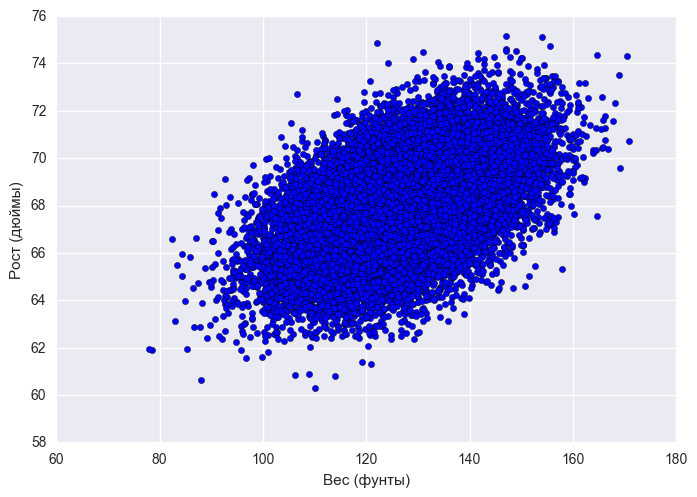

In [6]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [7]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

Обучите созданный вами `SGDRegressor` на выборке `(X_train_scaled, y_train)`. Параметры оставьте по умолчанию.

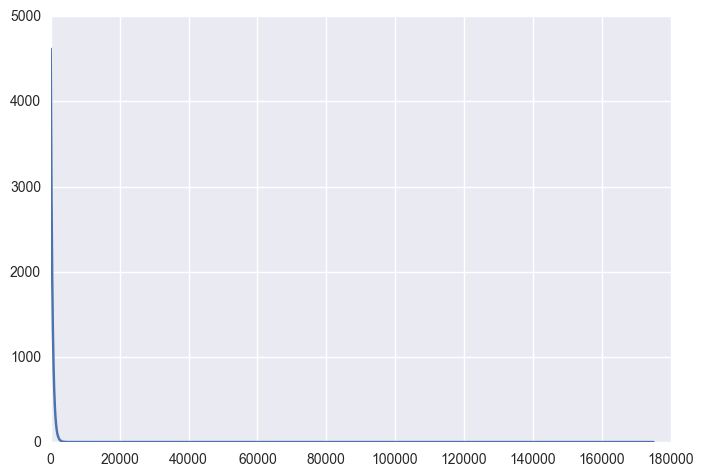

In [19]:
''' ВАШ КОД ЗДЕСЬ '''
sgd = SGDRegressor()
sgd.fit(X_train_scaled, y_train)
plt.plot(np.arange(len(sgd._mse)), sgd._mse)

Изобразите на графике процесс обучения – как среднеквадратичная ошибка зависит от номера итерации стохастического градиентного спуска.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

Выведите наименьшее значение среднеквадратичной ошибки и лучший вектор весов модели.

In [20]:
''' ВАШ КОД ЗДЕСЬ '''
np.min(sgd._mse)

2.7151352406643627

Постройте график того, как менялись значения весов модели ($w_0$ и $w_1$) по мере обучения.

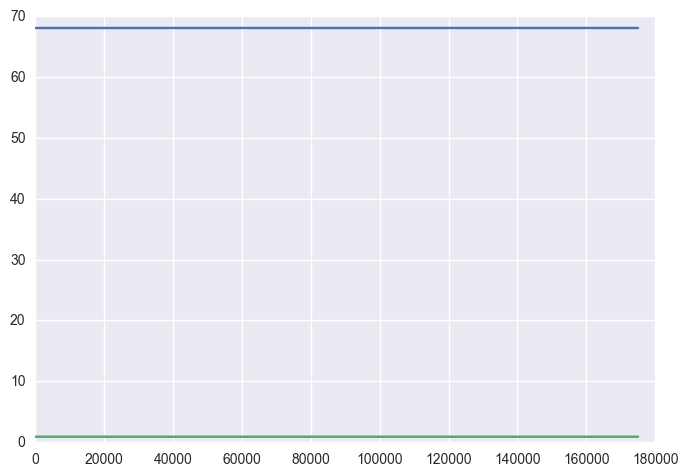

In [22]:
''' ВАШ КОД ЗДЕСЬ '''
plt.plot(np.arange(len(sgd._weights)), [it[0] for it in sgd._weights])
plt.plot(np.arange(len(sgd._weights)), [it[1] for it in sgd._weights])

Сделайте прогноз для отложенной выборки `(X_valid_scaled, y_valid)` и посмотрите на MSE.

In [23]:
''' ВАШ КОД ЗДЕСЬ '''
mean_squared_error(y_valid, sgd.predict(X_valid_scaled))

2.6758568913046146

Теперь следайте то же самое, но с `LinearRegression` из `sklearn.linear_model`. Посчитайте MSE для отложенной выборки.

In [24]:
''' ВАШ КОД ЗДЕСЬ '''
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
mean_squared_error(y_valid, lr.predict(X_valid_scaled))

2.6708307676676348

<font color='red'>Вопрос 1.</font> В каком знаке после разделителя отличаются MSE линейной регрессии и `SGDRegressor` для отложенной выборки?
 - 2
 - 3
 - 4
 - 5

In [ ]:
# ans 1: 3 ??

## 1.2. Логистическая регрессия и SGD
Теперь давайте разберемся, как при таком же стохастическом подходе обучать логистическую регрессию.

Задача классификации, $X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц), $y$ – вектор ответов, $y_i \in \{-1, 1\}$.
В [4 статье](https://habrahabr.ru/company/ods/blog/323890/) серии мы подробно разбирали, как логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=1}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

<font color='red'>Вопрос 2.</font> По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском?
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) +  \delta_{j\neq0} w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) +  \delta_{j\neq0}w_j)$
 - $w_j^{(t+1)} = w_j^{(t)} - \eta (Cy_i x_{ij} \sigma(y_iw^Tx_i) -  \delta_{j\neq0}w_j )$
 - $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $x_i$ – $i$-ая строка матрицы $X$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – небольшая константа, шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

In [ ]:
# ans 2: 4 (последняя) + - - ?

Реализуйте класс `SGDClassifier`. Спецификация:
- класс наследуется от `sklearn.base.BaseEstimator`
- конструктор принимает параметры `eta` – шаг градиентного спуска (по умолчанию $10^{-3}$), `n_iter` – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
- также в конструкторе должны создаваться списки `loss_` и `weights_` для отслеживания значений логистических потерь и вектора весов по итерациям градиентного спуска
- Класс имеет методы `fit`, `predict` и `predict_proba`
- Метод `fit` принимает матрицу `X` и вектор `y` (объекты `numpy.array`, рассматриваем только случай бинарной классификации, и значения в векторе `y` могут быть -1 и 1), добавляет к матрице `X` слева столбец из единиц, инициализирует вектор весов `w` **нулями** и в цикле с числом итераций `n_iter` обновляет веса по выведенной вами формуле, а также записывает получившиеся на данной итерации значения log_loss и вектор весов `w` в предназначенные для этого списки. 
- В конце метод `fit` создает переменную `w_`, в которой хранится тот вектор весов, при котором ошибка минимальна
- Метод `fit` должен возвращать текущий экземпляр класса `SGDClassifier`, т.е. `self`
- Метод `predict_proba` принимает матрицу `X`, добавляет к ней слева столбец из единиц и возвращает матрицу прогнозов модели (такую же, какую возвращают методы `predict_proba` моделей `sklearn`), используя созданный методом `fit` вектор весов `w_`
- Метод `predict` вызывает метод  `predict_proba` и возвращает вектор ответов: -1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
- И еще **важный момент**: во избежание вычислительных проблем из-за слишком больших или малых значений под экспонентной (overflow & underflow) используйте написанную функцию `sigma`

In [25]:
def sigma(z):
    z = z.flatten()
    z[z > 100] = 100
    z[z < -100] = -100
    return 1. / (1 + np.exp(-z))

In [74]:
from sklearn.metrics import log_loss

class SGDClassifier(BaseEstimator):
    ''' ВАШ КОД ЗДЕСЬ '''
    def __init__(self, C=1, eta=10**-3, n_iter=10):
        super().__init__()
        self._eta = eta
        self._n_iter = n_iter
        self._C = C
        self._loss = []
        self._weights = []
    
    def loss(self, X, y, w):
        return log_loss(y, sigma(np.dot(X, w)))
    
    def add_column(self, X):
        if len(X.shape) == 1:
            X = np.reshape(X, (X.shape[0], 1))
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        return X
    
    def fit(self, X, y):
        X = self.add_column(X)
        w = np.zeros(X.shape[1])
        for i in range(self._n_iter):
            for j in range(X.shape[0]):
                w = w + self._eta * ((self._C * y[j] * X[j, :] *
                                      sigma(- y[j] * np.dot(X[j, :], w))) -
                                      np.hstack([0, w[1:]]))
                self._weights.append(w[:])
                self._loss.append(self.loss(X, y, w))
        self._w = self._weights[np.argmin(self._loss)]
        return self
    
    def predict_proba(self, X):
        X = self.add_column(X)
        return log_loss(sigma(np.dot(X, w)))
    
    def predict(self, X):
        tmp = self.predict(X)
        tmp[tmp < 0.5] = -1
        tmp[tmp >= 0.5] = 1
        return tmp

Проверим `SGDClassifier` на данных UCI по раку молочной железы.

In [27]:
from sklearn.datasets import load_breast_cancer

In [28]:
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]

Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Обучите на масштибированной выборке `SGDClassifier` с параметрами `C`=1, `eta`=$10^{-3}$ и `n_iter`=3.

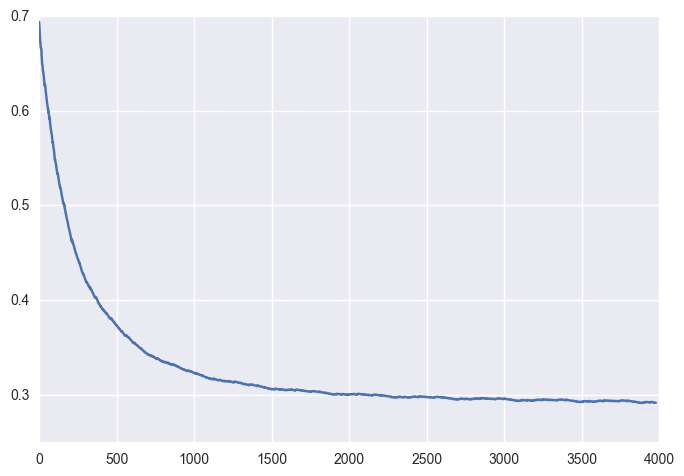

In [75]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_scaled, y_train)
plt.plot(np.arange(len(sgd_clf._loss)), sgd_clf._loss)

Постройте график изменения log_loss.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

Теперь обучите `SGDClassifier` с параметром `C`=1000, число проходов по выборке увеличьте до 10.

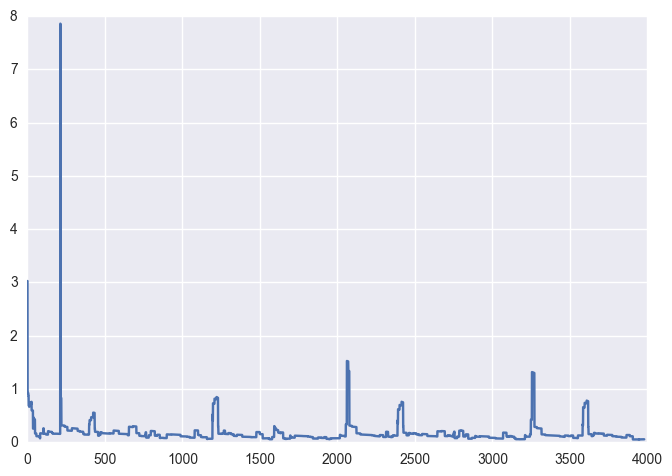

In [76]:
''' ВАШ КОД ЗДЕСЬ '''
sgd_clf = SGDClassifier(C=1000, n_iter=10)
sgd_clf.fit(X_train_scaled, y_train)
plt.plot(np.arange(len(sgd_clf._loss)), sgd_clf._loss)

Посмотрите на веса модели, при которых ошибка на обучении была минимальна.

<font color='red'>Вопрос 3.</font> Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели `SGDClassifier`? (будьте внимательны – проверьте длину вектора весов, полученного после обучения, сравните с числом признаков в исходной задаче)
 - worst compactness
 - worst smoothness
 - worst concavity
 - concave points error
 - concavity error
 - compactness error
 - worst fractal dimension

In [81]:
''' ВАШ КОД ЗДЕСЬ '''
weights = sgd_clf._w[1:]
np.argmin(sgd_clf._w[1:]), np.argmax(sgd_clf._w[1:]), np.argmax(np.abs(sgd_clf._w[1:]))

(26, 19, 26)

Посчитайте log_loss и ROC AUC на отложенной выборке, проделайте все то же с `sklearn.linear_model.LogisticRegression` (параметры по умолчанию, только random_state=17) и сравните результаты.

In [80]:
print(cancer.DESCR)

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

In [78]:
''' ВАШ КОД ЗДЕСЬ '''
for i, name in enumerate(zip(cancer.feature_names, weights)):
    print(i + 1, name)

1 ('mean radius', -1.6575531973741533)
2 ('mean texture', -3.4138735534809284)
3 ('mean perimeter', -1.4098222612879474)
4 ('mean area', -1.6649313452894046)
5 ('mean smoothness', -0.17720257064140754)
6 ('mean compactness', 1.9782699090761153)
7 ('mean concavity', -3.5669096433765652)
8 ('mean concave points', -3.5432757346362349)
9 ('mean symmetry', 0.4185013037061206)
10 ('mean fractal dimension', 2.8603495441985056)
11 ('radius error', -4.5318187974228064)
12 ('texture error', 2.791774302941854)
13 ('perimeter error', -2.5752886070631136)
14 ('area error', -3.1545840145111526)
15 ('smoothness error', 0.60303196005911108)
16 ('compactness error', 4.5350588374655167)
17 ('concavity error', 0.29303787559272326)
18 ('concave points error', 0.079666766481969881)
19 ('symmetry error', -0.52020555453862538)
20 ('fractal dimension error', 4.6606676990250584)
21 ('worst radius', -2.9241860576068124)
22 ('worst texture', -4.0515637077931519)
23 ('worst perimeter', -1.6395521948228353)
24 ('w

## 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

Теперь посмотрим на логистическую регрессию и ее же версию, но обучаемую стохастическим градиентным спуском, в задаче классификации отзывов IMDB. С этой задачей мы знакомы по 4 и 8 темам курса. Данные можно скачать [отсюда](https://yadi.sk/d/Tg1Tflur333iLr).

Импортируем файлы, и обучим на имеющихся данных `CountVectorizer`

In [82]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [84]:
# поменяйте путь к файлу
reviews_train = load_files("F:/Dev/moocs_std/ods_ml/data/reviews_data/")
text_train, y_train = reviews_train.data, reviews_train.target

In [86]:
reviews_test = load_files("F:\\Dev\\moocs_std\\ods_ml\\data\\aclImdb\\test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных `CountVectorizer`, считая биграммы, то есть перейдем к разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [22]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

CPU times: user 37.5 s, sys: 886 ms, total: 38.3 s
Wall time: 38.5 s


In [23]:
X_train.shape, X_test.shape

((25000, 1513832), (25000, 1513832))

Обучите на выборке `(X_train, y_train)` логистическую регрессию с параметрами по умолчанию (только укажите `random_state`=17) и посчитайте ROC AUC на тестовой выборке. Замерьте время обучения модели. Данные можно не масштабировать, так как признаки – по сути, счетчики, и они уже все измеряются примерно в одном диапазоне.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

Теперь перейдем к онлайн-алгоритму. Мы написали свой `SGDClassifier` и принцип его работы поняли, надо еще немного постараться, чтобы сделать его эффективным, например, сделать поддержку разреженных данных. Но мы теперь перейдем к `sklearn`-реализации SGD-алгоритма. Прочитайте документацию [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), сделайте выводы, чем `SGDClassifier` из `Sklearn` более продвинут, чем наша реализация SGD-классификатора. 

<font color='red'>Вопрос 4.</font> Чем `sklearn`-реализация стохастического классификатора более продвинута, чем `SGDClassifier`, который мы реализовали? Отметьте все подходящие варианты.
 - Изменяемый шаг градиентного спуска
 - Реализован линейный SVM
 - Реализована ранняя остановка во избежание переобучения
 - Есть распараллеливание по процессорам
 - Можно обучать LASSO
 - Поддерживается онлайн-обучение деревьев решений
 - Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному)


Проведите 100 итераций SGD-логрегрессии (опять `random_state`=17) на той же выборке. Опять замерьте время обучения модели и обратите внимание, насколько оно меньше, чем время обучения логистической регрессии.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

<font color='red'>Вопрос 5.</font> В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора `Sklearn` с логистической функцией потерь?
 - 2
 - 3
 - 4
 - 5